Group assignment: Second-level analysis
===

# 0. Setup

## Imports

In [12]:
import jupyter_black

jupyter_black.load()

In [88]:
from nipype import config
import os
from os.path import join as opj, abspath
import numpy as np
import pandas as pd
from nilearn import datasets, plotting, image
from pprint import pprint
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

template = datasets.load_mni152_template(resolution=1)

config.update_config(
    {
        "logging": {"workflow_level": "INFO"},
        "execution": {
            "stop_on_first_crash": "True",
            "hash_method": "content",
            "remove_unnecessary_outputs": "True",
        },
    }
)

contrast_dir_dict = {
    "navigation > baseline * cumulative distance error (vm)": "navigation",
    "obervation > baseline * cumulative distance error (vm)": "other",
    "observation > navigation": "other-self",
    "?": "self",
    "navigation > observation": "self-other",
}

# Check if ENV variables are set
print("'FSLDIR':", os.environ["FSLDIR"])
print("'FSLOUTPUTTYPE':", os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

'FSLDIR': /opt/fsl-5.0.11
'FSLOUTPUTTYPE': NIFTI


# Second-level analysis

## Basic model for `other > self` (**A**)

### Download data

In [89]:
chosen_contrast = "observation > navigation"


data_dir = (
    "data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/"
    + contrast_dir_dict[chosen_contrast]
    + "-AllSessions"
)

print(f"data is stored in: {abspath(data_dir)}")

cmaps = sorted(
    glob(
        f"{abspath(data_dir)}/**/*.nii",
        recursive=True,
    )
)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]

data is stored in: /main/assignments/Group assignment/data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/other-self-AllSessions

There are 59 contrast maps


In [16]:
# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

design_matrix.head()

,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1


In [17]:
from nilearn.glm.second_level import SecondLevelModel

second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix=design_matrix)

other_self = second_level.compute_contrast(
    second_level_contrast="intercept", output_type="stat", second_level_stat_type="t"
)

## Correcting multiple comparisons

<div class="alert alert-warning">Do we need the complete image with all the negative activations for calculating the threshold?</div>

### Thresholded map

In [18]:
from nilearn.glm import threshold_stats_img
from nilearn.image import resample_to_img


thresholded_map, threshold = threshold_stats_img(
    other_self, alpha=0.001, height_control="fdr", cluster_threshold=80, two_sided=True
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)

The FDR=.05 threshold is 3.541


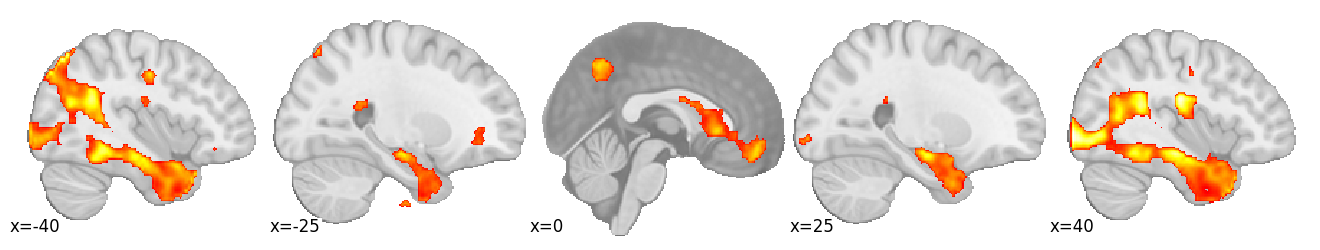

In [19]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

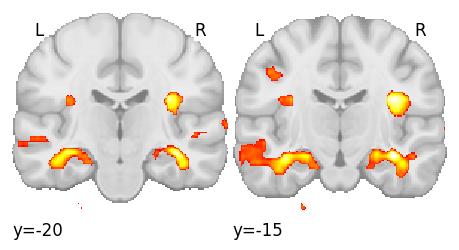

In [54]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

## Surface plots

In [75]:
from nilearn import surface
from nilearn import datasets

# for higher resolution
big_fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
big_texture_r = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_right)
big_texture_l = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_left)

### Multiple views

with higher resolution (`surf_mesh` argument)

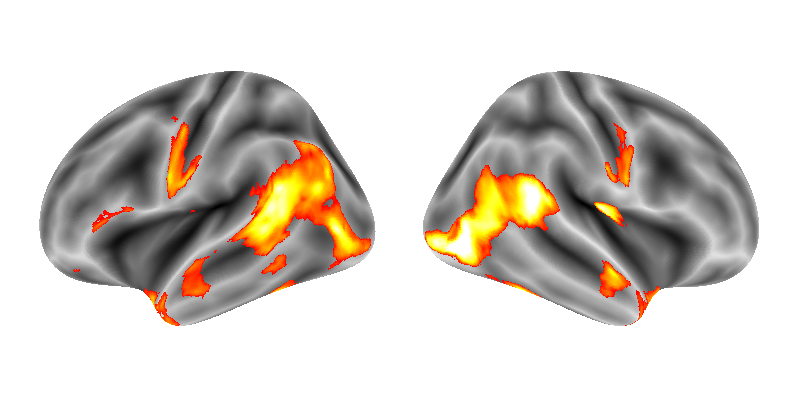

In [23]:
plotting.plot_img_on_surf(
    thresholded_map_pos,
    surf_mesh=big_fsaverage,
    views=["lateral"],
    hemispheres=["left", "right"],
    threshold=threshold,
    colorbar=False,
    inflate=True,
    vmax=10,
)
plotting.show()

## Multiplot figure

/tmp/ipykernel_15/2632295950.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("multiplot_figure.png")
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


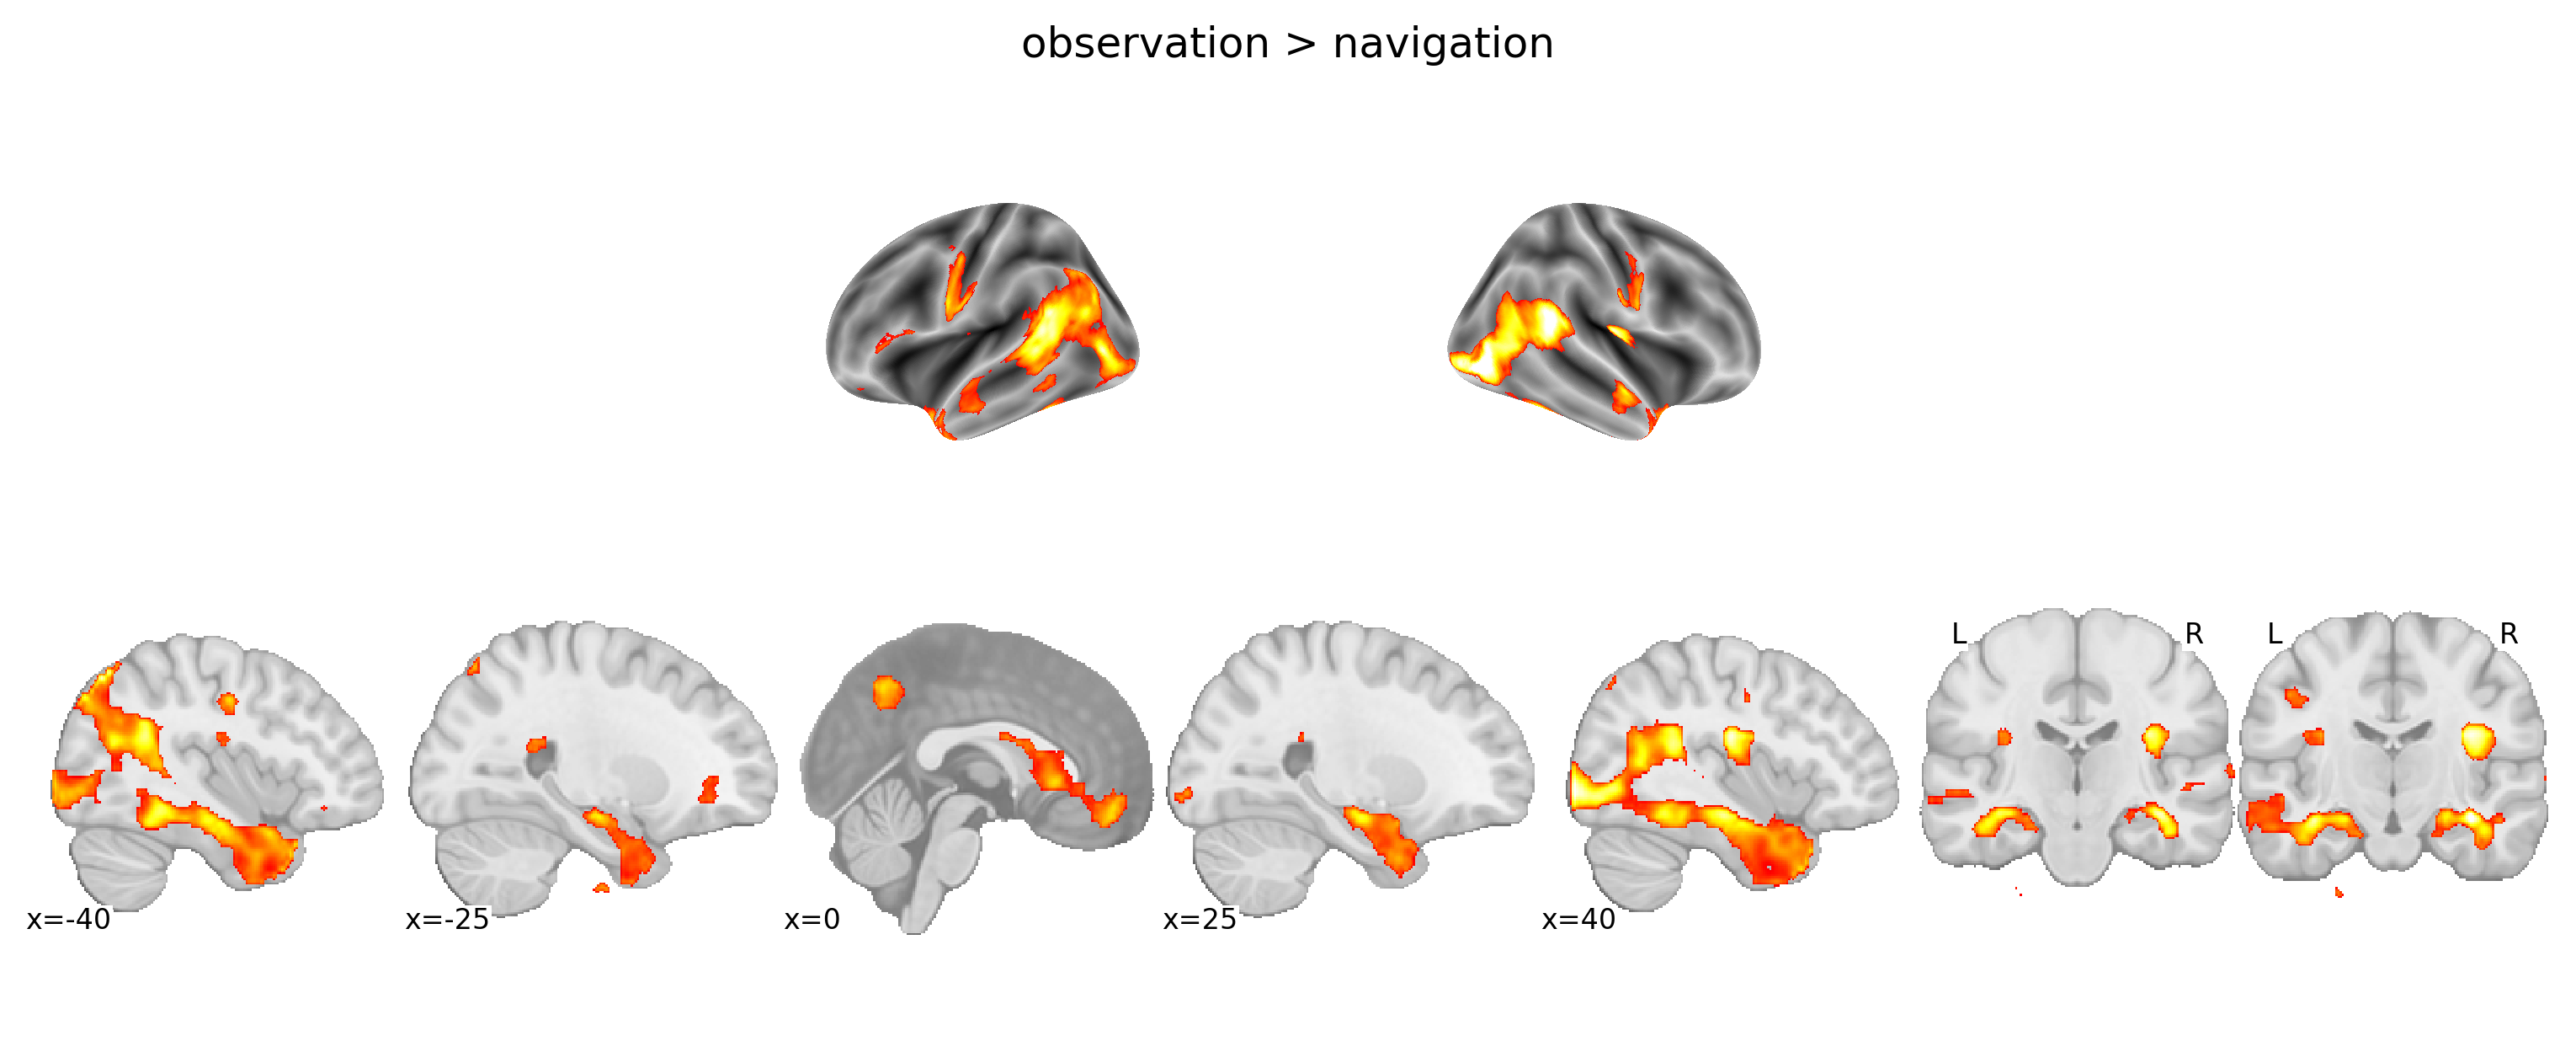

In [85]:
fig = plt.figure(figsize=(10, 4), dpi=300)
#  rc('font', size=8)

plot_upper_l = fig.add_subplot(2, 4, 2, projection="3d")

plotting.plot_surf_stat_map(
    big_fsaverage.infl_left,
    big_texture_l,
    hemi="left",
    view="lateral",
    colorbar=False,
    threshold=threshold,
    bg_map=big_fsaverage.sulc_left,
    vmax=10,
    figure=fig,
    axes=plot_upper_l,
)


plot_upper_r = fig.add_subplot(2, 4, 3, projection="3d")
plotting.plot_surf_stat_map(
    big_fsaverage.infl_right,
    big_texture_r,
    hemi="right",
    view="lateral",
    colorbar=False,
    threshold=threshold,
    bg_map=big_fsaverage.sulc_right,
    vmax=10,
    figure=fig,
    axes=plot_upper_r,
)


plot_left = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0, 0, 0.75, 0.48),  # axes = (xmin, ymin, width, height)
)

plot_left.annotate(left_right=False, positions=True, size=8, scale_loc="center")

plot_right = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0.75, 0, 0.25, 0.48),
)

plot_right.annotate(left_right=True, positions=False, size=8, scale_loc="center")

fig.suptitle(chosen_contrast)

fig.savefig("multiplot_figure.png")

## Glass brain plot for contrast `obervation > baseline * cumulative distance error (vm)`

In [91]:
chosen_contrast = "obervation > baseline * cumulative distance error (vm)"


data_dir = (
    "data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/"
    + contrast_dir_dict[chosen_contrast]
    + "-AllSessions"
)

print(f"data is stored in: {abspath(data_dir)}")

cmaps = sorted(
    glob(
        f"{abspath(data_dir)}/**/*.nii",
        recursive=True,
    )
)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]

data is stored in: /main/assignments/Group assignment/data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/other-AllSessions

There are 59 contrast maps


In [181]:
# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

dist_err = pd.read_excel("data_Wagner_NatComms_2022/avgDistErr_20210408.xlsx")
dist_err["subjn"] = "sub-" + dist_err["subjn"].astype(str).str.zfill(2)
dist_err = dist_err.set_index("subjn")

design_matrix = design_matrix.merge(
    dist_err["mean"], left_index=True, right_index=True
).rename(columns={"mean": "distance_error"})

design_matrix.head()

,intercept,distance_error
sub-01,1,19.41951
sub-02,1,26.60407
sub-03,1,10.69242
sub-04,1,27.78675
sub-05,1,14.30383


<div class="alert alert-warning">How to correctly specify the interaction?</div>

The FDR=.001 threshold is 3.919


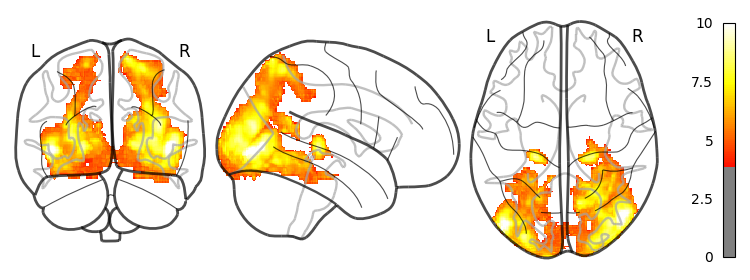

In [184]:
# Filter filepaths of cmaps to available data

import re


def check_available(filepath, mat):
    number = re.findall("S[0-9][0-9]_", filepath)[0].replace("S", "").replace("_", "")
    res = "sub-" + number
    res = res in mat.index
    return res


cmaps_filtered = [cm for cm in cmaps if check_available(cm, design_matrix)]

second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps_filtered, design_matrix=design_matrix)

other_baseline = second_level.compute_contrast(
    second_level_contrast="intercept + distance_error",
    output_type="stat",
    second_level_stat_type="t",
)

thresholded_map, threshold = threshold_stats_img(
    other_baseline,
    alpha=0.001,
    height_control="fdr",
    cluster_threshold=80,
    two_sided=True,
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)


plotting.plot_glass_brain(
    thresholded_map_pos, threshold=threshold, colorbar=True, vmax=10, cmap="cold_hot"
)

# 2. Store objects

Save

In [16]:
import pickle

pickle.dump(second_level, open("second_level.pkl", "wb"))
!ls ./

'Group assignment.ipynb'   data   data_Wagner_NatComms_2022   second_level.pkl


Load

In [17]:
secondlvl_pkl = pickle.load(open("second_level.pkl", "rb"))

secondlvl_pkl.design_matrix_.head()

,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1


As we have pickled the already fitted object, we can go ahead and evaluate some contrasts (without fitting the model again):

/usr/local/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


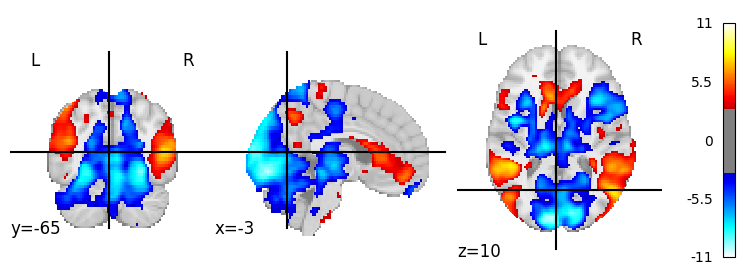

In [18]:
other_self_pkl = secondlvl_pkl.compute_contrast(
    second_level_contrast="intercept", output_type="z_score"
)

plotting.plot_stat_map(other_self_pkl, threshold=3)